In [1]:
from google.colab import drive
drive.mount('/content/gdrive')
! cp /content/gdrive/MyDrive/TheCatheterNinjas/kaggle.json /content/


Mounted at /content/gdrive


In [ ]:
data = '/content/gdrive/MyDrive/TheCatheterNinjas/ranzcr-clip-catheter-line-classification'

In [2]:
import os
if 'google.colab' in str(get_ipython()):
    print('Running on CoLab')
    colab = True
    drive.mount('/content/gdrive')
    DATA = '/content/gdrive/MyDrive/TheCatheterNinjas/ranzcr-clip-catheter-line-classification'
else:
    colab = False
    print('Not running on CoLab')

Running on CoLab


In [3]:
if colab:
    if not download:
        ! pip install --upgrade --force-reinstall --no-deps kaggle
        ! mkdir /root/.kaggle
        ! cp kaggle.json /root/.kaggle/
        ! chmod 600 /root/.kaggle/kaggle.json
        ! kaggle competitions download -c ranzcr-clip-catheter-line-classification -p ./data/
        ! unzip -qq ./data/'*.zip' -d ./data
        ! rm ./data/'ranzcr-clip-catheter-line-classification.zip'
        download = True

     |████████████████████████████████| 61kB 8.9MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.10-cp36-none-any.whl size=73269 sha256=cb61f3eb9ff9d6e4dc774c7d6df0771b80969de64b7a45b23999bc441117eddd
  Stored in directory: /root/.cache/pip/wheels/3a/d1/7e/6ce09b72b770149802c653a02783821629146983ee5a360f10
Successfully built kaggle
  Found existing installation: kaggle 1.5.10
    Uninstalling kaggle-1.5.10:
      Successfully uninstalled kaggle-1.5.10
100% 11.7G/11.7G [04:41<00:00, 68.4MB/s]
100% 11.7G/11.7G [04:41<00:00, 44.6MB/s]


# Info

- building a baseline model using cats vs. dogs architecture, modified by the addition of 2 dropout layers as advised by Omer.
- this baseline model includes a preprocessing steps of rescaling of all images to 448x448 size with a single channel (gray scale)
- this baseline model is built for multi-label classification:
    - output layer has a Sigmoid activation function 
    - loss function is binary_crossentropy
    - chosen metrics is AUC with multi-label parameter set to True (as compatible with the competition requirements)

# Setup

## import libraries and modules

In [4]:
! pip install livelossplot

In [5]:
import matplotlib.pyplot as plt
import warnings
import datetime
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)
import cv2
import os
import numpy as np
from pathlib import Path
from multiprocessing import Pool
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten,Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from tensorflow.keras.metrics import AUC, Precision, Recall
from sklearn.model_selection import train_test_split, GroupShuffleSplit
import pickle
from sklearn.metrics import classification_report, roc_curve, auc
from scipy import interp
from livelossplot import PlotLossesKeras
%matplotlib inline

## set constants

In [6]:
DATA = Path('data/')

# input files and directories
TRAIN_META = DATA / 'train.csv'
TRAIN_IMG_DIR = DATA / 'train/'
TEST_IMG_DIR = DATA / 'test/'

# output files and directories
BASE =  Path ('BaseLine/')
TRAIN_RESIZE_DIR =  BASE / 'train_resize'
TEST_RESIZE_DIR = BASE / 'test_resize'
MODEL_CHECKPOINT = BASE / 'Checkpoint/weights.{epoch:02d}-{val_loss:.2f}.hdf5'
SERIALIZED =  BASE / 'Serialized'
MODEL =  SERIALIZED / 'model.json'
MODEL_WEIGHTS =  SERIALIZED / 'weights.h5'
MODEL_HISTORY =  SERIALIZED / 'history.pkl'

# generate output directories in case not exist
os.makedirs(TRAIN_RESIZE_DIR, exist_ok=True)
os.makedirs(TEST_RESIZE_DIR, exist_ok=True)
os.makedirs(SERIALIZED, exist_ok=True)

CASE = 'StudyInstanceUID'
ID = 'PatientID'

# constants for preprocessing
NEW_SIZE = (244,244)
IMG_SIZE = NEW_SIZE + (1, )

# parameters for sequential model
RSCL = 1/255
N_FILTERS = 64
FILTER2D_size = 1
ACTIVATION = 'relu'
RATE = 0.5
DENSE_DIM = 64
OUT_ACTIVATION = 'sigmoid'

# parameters for callbacks

MONITOR = 'val_loss'
PATIENCE = 2

# parameters for compilation
METRICS=[AUC(multi_label=True), Precision(), Recall()]
OPTIMIZER = 'adam'
LOSS = 'binary_crossentropy'

# parameters for fitting
EPOCHS = 100
BATCH_SIZE = 32

# general
RANDOM_STATE = 42
TEST_VALIDATION_SIZE = 0.2
AVAIL_CPU = None

np.random.seed(RANDOM_STATE)

## load meta file

In [7]:
df = pd.read_csv(TRAIN_META)

In [8]:
df.head()

,StudyInstanceUID,ETT - Abnormal,ETT - Borderline,ETT - Normal,NGT - Abnormal,NGT - Borderline,NGT - Incompletely Imaged,NGT - Normal,CVC - Abnormal,CVC - Borderline,CVC - Normal,Swan Ganz Catheter Present,PatientID
0,1.2.826.0.1.3680043.8.498.26697628953273228189...,0,0,0,0,0,0,1,0,0,0,0,ec89415d1
1,1.2.826.0.1.3680043.8.498.46302891597398758759...,0,0,1,0,0,1,0,0,0,1,0,bf4c6da3c
2,1.2.826.0.1.3680043.8.498.23819260719748494858...,0,0,0,0,0,0,0,0,1,0,0,3fc1c97e5
3,1.2.826.0.1.3680043.8.498.68286643202323212801...,0,0,0,0,0,0,0,1,0,0,0,c31019814
4,1.2.826.0.1.3680043.8.498.10050203009225938259...,0,0,0,0,0,0,0,0,0,1,0,207685cd1


## get labels

In [9]:
labels = df.select_dtypes(int).columns
print(labels)

Index(['ETT - Abnormal', 'ETT - Borderline', 'ETT - Normal', 'NGT - Abnormal',
       'NGT - Borderline', 'NGT - Incompletely Imaged', 'NGT - Normal',
       'CVC - Abnormal', 'CVC - Borderline', 'CVC - Normal',
       'Swan Ganz Catheter Present'],
      dtype='object')


## help functions

In [10]:
def show_img(img: np.array, axes=None, title: str='', cmap: str = 'gray'):
    """
    This function gets an image as a numpy array and show it.
    default on grayscale
    """
    if not axes:
        _, axes = plt.subplots()
    axes.imshow(img, cmap=cmap)
    axes.set_title(title)
    
def preprocess(img_path: Path, processed_path: Path, size = NEW_SIZE, 
               scale=cv2.IMREAD_GRAYSCALE):
    """
    This function gets a path to an image,
    resize it to a given size and saves it back to the drive.
    """
    new_img = cv2.resize(cv2.imread(str(img_path), scale), size)
    cv2.imwrite(str(processed_path), new_img)
    if colab:  # added to save space on google colab drive.
        os.remove(str(img_path))

    

def validate_file(record: Path):
    """
    This function gets a path and checkes if there is a file for that path.
    """
    if record.is_file() & record.exists():
        return True
    return False


def numipy_train(meta: pd.DataFrame, img_dir: Path,
                 suffix: str = '.jpg', case_col: str = CASE, 
                 labels_col = labels, 
                 scale=cv2.IMREAD_GRAYSCALE, 
                 image_dir_temp_col = 'images', cpu: int=None):
    """
    This functino gets a Panda's dataframe with a path to the image files and 
    returns numpy array for those images and the currect lables from the train file.
    """
    if colab:
        meta[image_dir_temp_col] = (meta[case_col] + suffix).apply(lambda img_path: img_dir / img_path)
    else:
        meta[image_dir_temp_col] = img_dir / (meta[case_col] + suffix)
    msk = meta[image_dir_temp_col].apply(validate_file)
    meta = meta[msk]
    images, label_values = meta[image_dir_temp_col].to_list(), meta[labels_col].values
    images = [(str(image), scale) for image in images]
    with Pool(cpu) as p: images = p.starmap(cv2.imread, images)
    return np.array(images), label_values

def numipy_test(img_dir: Path, suffix: str = '.jpg',
                 scale=cv2.IMREAD_GRAYSCALE, cpu: int=None):
    """
    This functino gets a Panda's dataframe with a path to the image files and 
    returns numpy array for those images.
    """
    
    images = list(img_dir.glob('*' + suffix))
    images = [(str(image), scale) for image in images]
    with Pool(cpu) as p: images = p.starmap(cv2.imread, images)
    return np.array(images)
    

def multi_preprocess(input_dir: Path, output_dir: Path, glob: str='*.jpg',
                      size: tuple=NEW_SIZE, scale=cv2.IMREAD_GRAYSCALE, 
                      cpu: int=None):
    """
    This function gets the path to a folder with all images and does 
    preprocessing on all the .jpg files on that folder.
    """
    pool_lst = []
    os.makedirs(output_dir, exist_ok=True)
    for input_img in input_dir.glob(glob):
        pool_lst.append((input_img, output_dir/input_img.name, size, scale))
    with Pool(cpu) as p: p.starmap(preprocess, pool_lst)


## set image generators

In [11]:
df[CASE] = df[CASE].apply(lambda name: name+'.jpg')

In [13]:
train_inds, test_val_inds = next(GroupShuffleSplit(test_size=TEST_VALIDATION_SIZE,
                      n_splits=1,
                      random_state = RANDOM_STATE).\
                            split(df, groups=df[ID]))
val_inds, test_inds = next(GroupShuffleSplit(test_size=0.5,
                      n_splits=1,
                      random_state = RANDOM_STATE).\
                            split(df.loc[test_val_inds],
                                  groups=df.loc[test_val_inds][ID]))

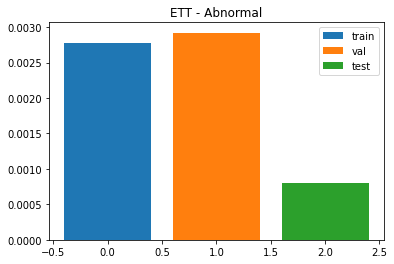

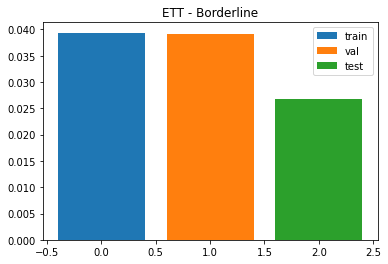

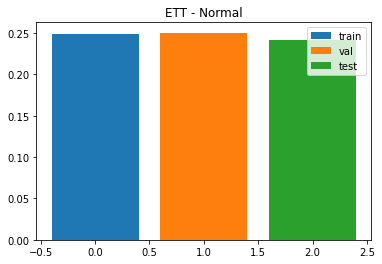

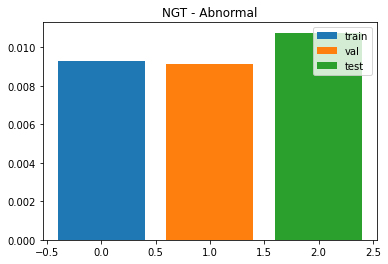

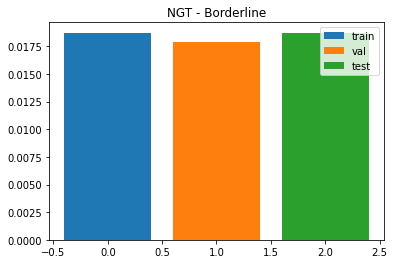

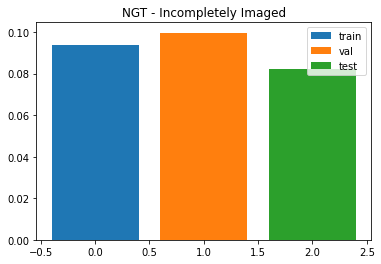

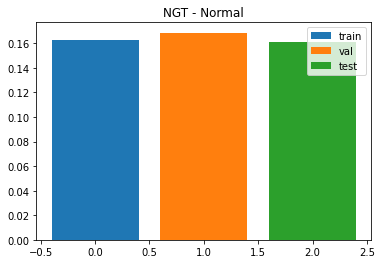

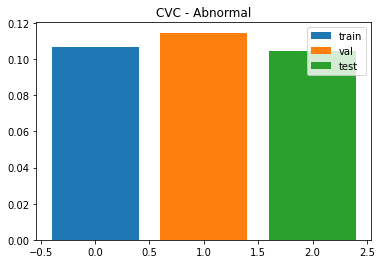

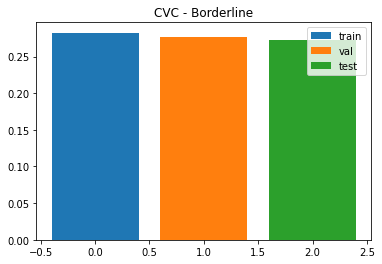

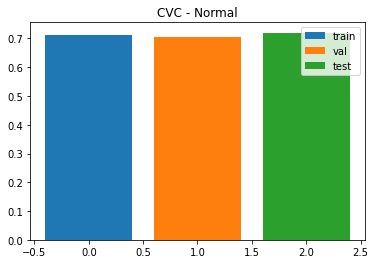

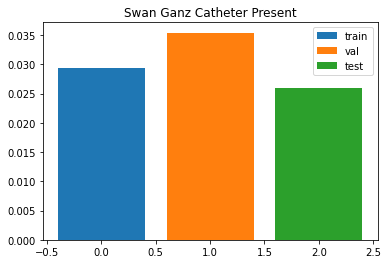

In [64]:
for label in labels:
    plt.title(label)
    plt.bar(0, df.iloc[train_inds][label].value_counts(1)[1], label='train')
    plt.bar(1, df.iloc[val_inds][label].value_counts(1)[1], label='val')
    plt.bar(2, df.iloc[test_inds][label].value_counts(1)[1], label='test')
    plt.legend()
    plt.show()

In [14]:
gen_properties = {'featurewise_center':False,
    'samplewise_center':False,
    'featurewise_std_normalization':False,
    'samplewise_std_normalization':False,
    'zca_whitening':False,
    'zca_epsilon':1e-06,
    'rotation_range':0,
    'width_shift_range':0.0,
    'height_shift_range':0.0,
    'brightness_range':None,
    'shear_range':0.0,
    'zoom_range':0.0,
    'channel_shift_range':0.0,
    'fill_mode':"nearest",
    'cval':0.0,
    'horizontal_flip':False,
    'vertical_flip':False,
    'rescale':RSCL,
    'preprocessing_function':None,
    'data_format':None,
    'validation_split':0.0,
    'dtype':None,}

In [15]:
train_datagen=tf.keras.preprocessing.image.ImageDataGenerator(**gen_properties)
val_datagen=tf.keras.preprocessing.image.ImageDataGenerator(**gen_properties)
test_datagen=tf.keras.preprocessing.image.ImageDataGenerator(**gen_properties)

print('train data:')
train_generator=train_datagen.flow_from_dataframe(
    dataframe=df.iloc[train_inds],
    directory=TRAIN_IMG_DIR,
    x_col=CASE,
    y_col=labels,
    batch_size=BATCH_SIZE,
    color_mode="grayscale",
    seed=RANDOM_STATE,
    shuffle=True,
    class_mode="raw",
    target_size=NEW_SIZE)

print('\nval data:')
val_generator=val_datagen.flow_from_dataframe(
    dataframe=df.iloc[val_inds],
    directory=TRAIN_IMG_DIR,
    x_col=CASE,
    y_col=labels,
    batch_size=BATCH_SIZE,
    color_mode="grayscale",
    seed=RANDOM_STATE,
    shuffle=True,
    class_mode="raw",
    target_size=NEW_SIZE)

print('\ntest data:')
test_generator=test_datagen.flow_from_dataframe(
    dataframe=df.iloc[test_inds],
    directory=TRAIN_IMG_DIR,
    x_col=CASE,
    y_col=labels,
    batch_size=BATCH_SIZE,
    color_mode="grayscale",
    seed=RANDOM_STATE,
    shuffle=True,
    class_mode="raw",
    target_size=NEW_SIZE)

train data:
Found 24833 validated image filenames.

val data:
Found 2739 validated image filenames.

test data:
Found 2511 validated image filenames.


# Preprocess

## preprocess train

# basic CNN

## make sequential model architecture

In [65]:
layers = []
#layers.append(Rescaling(RSCL, input_shape=IMG_SIZE, name='rescale')) # rescaling layer
layers.append(Conv2D(N_FILTERS, FILTER2D_size, input_shape=IMG_SIZE, activation=ACTIVATION, name='conv_1')) # 1st conv layer
layers.append(MaxPooling2D(name='max_pool1')) # 1st max pooling layer
layers.append(Conv2D(N_FILTERS, FILTER2D_size, activation=ACTIVATION, name='conv_2')) # 2nd conv layer
layers.append(MaxPooling2D(name='max_pool2')) # 2nd max pooling layer
layers.append(Conv2D(N_FILTERS, FILTER2D_size, activation=ACTIVATION, name='conv_3')) # 3nd conv layer
layers.append(MaxPooling2D(name='max_pool3')) # 3rd  max pooling layer
layers.append(Flatten(name='flat')) # flatten layer
layers.append(Dropout(RATE, name='dropout_1')) # Dropout layer
layers.append(Dense(DENSE_DIM, activation=ACTIVATION, name='dense')) # 1st fully connected layer
layers.append(Dropout(RATE, name='dropout_2'),) # Dropout layer
layers.append(Dense(len(labels), activation=OUT_ACTIVATION, name='out')) # 2nd fully connected layer
model = Sequential(layers, name='BaseModel')

## model summary

In [66]:
model.summary()

Model: "BaseModel"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_1 (Conv2D)              (None, 244, 244, 64)      128       
_________________________________________________________________
max_pool1 (MaxPooling2D)     (None, 122, 122, 64)      0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 122, 122, 64)      4160      
_________________________________________________________________
max_pool2 (MaxPooling2D)     (None, 61, 61, 64)        0         
_________________________________________________________________
conv_3 (Conv2D)              (None, 61, 61, 64)        4160      
_________________________________________________________________
max_pool3 (MaxPooling2D)     (None, 30, 30, 64)        0         
_________________________________________________________________
flat (Flatten)               (None, 57600)             0 

## compile model

In [67]:
model.compile(optimizer=OPTIMIZER, loss=LOSS, metrics=METRICS)

## Callbacks

In [ ]:
checkpoint = ModelCheckpoint(
    MODEL_CHECKPOINT, monitor=MONITOR, verbose=1, save_best_only=True,
    save_weights_only=False, mode='auto')
ES = EarlyStopping(monitor=MONITOR, patience=PATIENCE)
live_plot = PlotLossesKeras()

# train

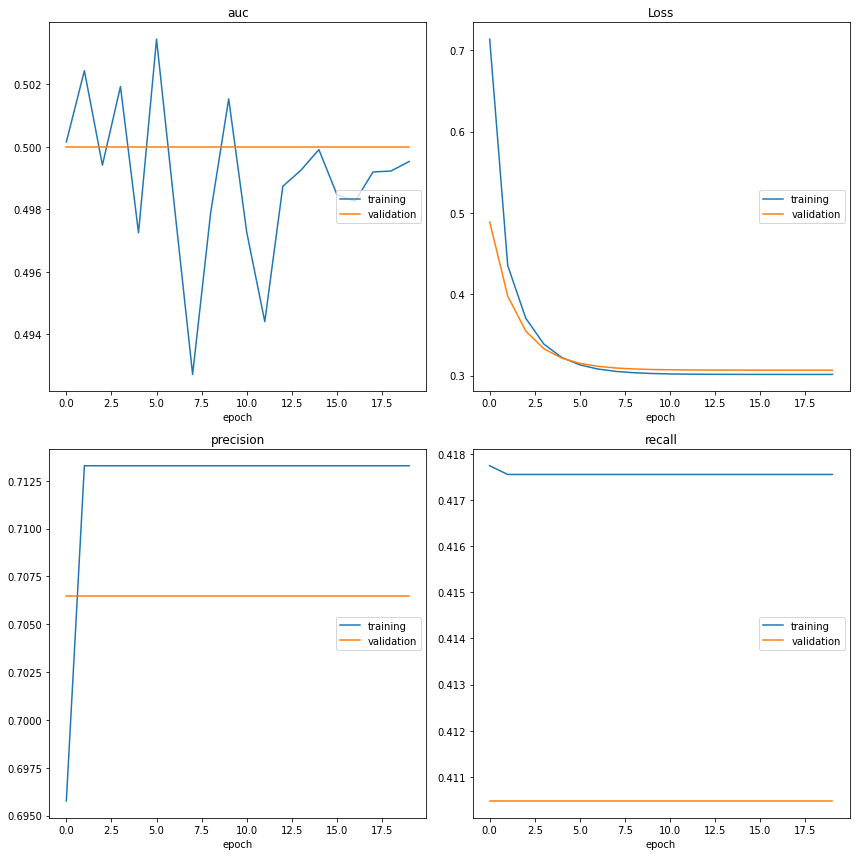

auc
	training         	 (min:    0.493, max:    0.503, cur:    0.500)
	validation       	 (min:    0.500, max:    0.500, cur:    0.500)
Loss
	training         	 (min:    0.301, max:    0.714, cur:    0.301)
	validation       	 (min:    0.307, max:    0.489, cur:    0.307)
precision
	training         	 (min:    0.696, max:    0.713, cur:    0.713)
	validation       	 (min:    0.706, max:    0.706, cur:    0.706)
recall
	training         	 (min:    0.418, max:    0.418, cur:    0.418)
	validation       	 (min:    0.410, max:    0.410, cur:    0.410)


In [ ]:
model.fit(x=train_generator,
          validation_data=valid_generator,
          batch_size=BATCH_SIZE,
          epochs=EPOCHS,
          callbacks=[checkpoint, ES, live_plot])

# Saving the model to file

In [ ]:
model_name = str(datetime.date.today())

In [ ]:
! rm -r '/content/gdrive/MyDrive/TheCatheterNinjas/saved_model/{model_name}'
model.save(f'/content/gdrive/MyDrive/TheCatheterNinjas/saved_model/{model_name}')

rm: cannot remove '/content/gdrive/MyDrive/TheCatheterNinjas/saved_model/2021-02-04': No such file or directory
INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/TheCatheterNinjas/saved_model/2021-02-04/assets


# Evaluating the model

In [ ]:
model = tf.keras.models.load_model(f'/content/gdrive/MyDrive/TheCatheterNinjas/saved_model/{model_name}')

In [68]:
true = test_generator.labels

In [69]:
pred = model.predict(test_generator)

### plotting - each label separately

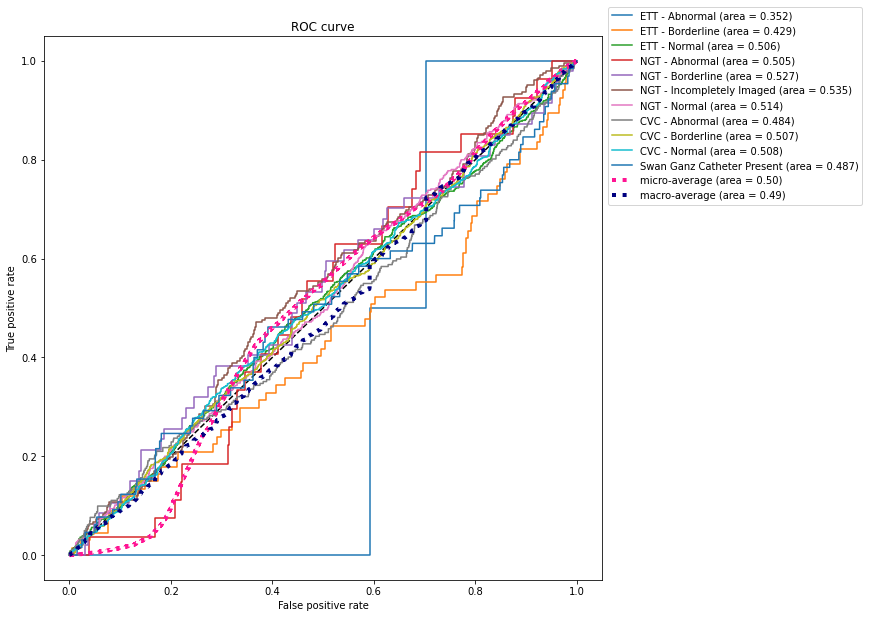

In [70]:
_, ax = plt.subplots(figsize=(10,10))
ax.plot([0, 1], [0, 1], 'k--')
fprs, tprs = [], []
n_classes = len(labels)

fpr_sum, tpr_sum = 0, 0
for i, label in enumerate(labels):
    label_fpr, label_tpr, thresh = roc_curve(true[:, i], pred[:, i])
    label_auc = auc(label_fpr, label_tpr)
    ax.plot(label_fpr, label_tpr, label='{} (area = {:.3f})'.format(label, label_auc))
    fprs.append(label_fpr)
    tprs.append(label_tpr)

     
# micro 
fpr_micro, tpr_micro, _ = roc_curve(true.ravel(), pred.ravel())
auc_micro = auc(fpr_micro, tpr_micro)

ax.plot(fpr_micro, tpr_micro,
         label='micro-average (area = {0:0.2f})'.format(auc_micro), 
        color='deeppink', linestyle=':', linewidth=4)
    
# macro 
all_fpr = np.unique(np.concatenate(fprs))
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fprs[i], tprs[i])
mean_tpr/=n_classes
fpr_macro = all_fpr
tpr_macro = mean_tpr
auc_macro = auc(fpr_macro, tpr_macro)

ax.plot(fpr_macro, tpr_macro, 
        label='macro-average (area = {0:0.2f})'.format(auc_macro),
         color='navy', linestyle=':', linewidth=4)

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc=(1.01,0.69))
plt.show()

## classification report

In [ ]:
#print(classification_report(y_test, y_predicted_label, target_names=labels))